# Introducción al manejo de audio en Python y preprocesamiento de datasets de audio



En este tutorial buscaremos introducir conceptos básicos de audio, y como vizualizar datos musicales y audio en python, y procesarlo para su uso en programas de Machine Learning. 

Este tutorial está basado en la serie de [Deep Learning para audio de Valerio Velardo](https://www.youtube.com/watch?v=fMqL5vckiU0&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf).

## Parte 1: Audio


Al decir audio o sonido, nos estámos refiriendo a ondas mecanicas que tienen ciertas caracteristicas o cualidades de interés. Particularmente, nos enfocarémos en:
* Tono : Depende de la frecuencia de la onda y determina la gravedad o agudéz del sonido.
* Duración : Se refiere al tiempo en el que se mantiene el sonido.
* Intensidad: Depende de la amplitud de la onda sonora, y determina si el sonido es fuerte o debil.
* Timbre: Analogo con la textura, permite identificar sonidos que provienen de distintas fuentes, y depende de la forma misma de la onda sonora.

Para trabajar con audio en ML, debemos entender bien estas cualidades, y poder representarlas de manera numerica y digital. 

### Conversión Analógica Digital



Para representar de manera digital una señal de audio, usamos Conversión Analógica Digital (CAD). Este proceso consiste en identificar las cualidades de la señal en intervalos uniformes de tiempo, y mappear la amplitud con una cierta cantidad de bits. De esta manera se puede digitalizar audio analogico.

![CAD](files/images/MuestreoDigital.png)


Este proceso depende de dos metricas:

* Sample rate, o frecuencia de muestreo: Puntos muestreados por segundo de audio. Se mide en Hz.
* Bit depth, o profundidad de bits: Representa la cantidad de informacion guardada en cada punto del muestreo. Equivale a la resolución del sonido.
 
Por ejemplo, los CDs tienen la capacidad de guardar audio con una frecuencia de muestreo de 44100 Hz y una profundidad de bits de 16.



### Transformada de Fourier



Muchas veces es dificil visualizar la formacion de ondas sonoras reales, puesto que son muy complejas. La transformada de Fourier nos permite convertir cualquier sonido periodico complejo a una suma de curvas sinusoidales de distintas frecuencias. Ademas nos permite visualizar la onda como la magnitud funcion de la frecuencia, y no del tiempo. 

![FT](files/images/Fourier-transform.gif)


Visualizando el espectro de frecuencia, podemos ver que frecuencia tiene mayor importancia en la onda. El problema de este espectro es su caracter instantaneo, pues al no depender del tiempo, este espectro nos da datos de un instante de la onda. 


### STFT

Para solucionar este problema empleamos STFT(short time fourier transform). Este metodo consiste en realizar transformadas de Fourier en distintos intervalos iguales, para poder graficar la magnitud en funcion de la frecuencia, en funcion del tiempo.Esto se llama un espectograma. 

![STFT](files/images/stft_spectogram.png)


El tamaño de los interfalos viene dado por un parametro Frame Size, que indica cuantos puntos de muestreo se encuentran dentro de cada intervalo de transformadas de Fourier.

Estos espectogramas son de gran importancia para el entrenamiento de redes neuronales artificiales en base a audio, pues son la forma más eficiente de numerizar y procesar la informacion auditiva para este fin. 

### MFCCs


Ya podemos medir tres de nuestras cuatro cualidades funcamentales, siendo frecuencia, magnitud o intensidad y duracion. Pero nos falta todavia una parte importante de la ecuacion, el timbre! Es aqui donde entran los MFCCs.

Los MFCCs(Mel Frecuency Cepstral Coefficients) son mediciones de timbre y textura relativos respecto a la frecuencia, expresados como un vector que suele variar entre 13 y 40 coefficientes, y buscan aproximar de la mejor manera posible las diferencias que detecta el oido humano.  

Analogamente con STFT, podemos estudiar el comportamiento de los MFCCs en cada instante de audio, opteniendo un espectrograma de MFCCs en el tiempo.

![MFCC](files/images/MFCCs.png)

Estas mediciones son de gran importancia para applicaciones de Machine Learning, y son la base de programas de reconocimiento de voz, clasificación de generos musicales y clasificación de instrumentos, entre otros.

## Parte 2: Audio en Python

Para manejar audio en Python usaremos la libreria "librosa" version 0.7.2. 


Primero cargaremos el archivo:

In [1]:
import librosa, librosa.display # Importamos librosa y librosa display, que permite visualizar audio
import matplotlib.pyplot as plt # librosa.display funciona en base a matplotlib
import IPython.display as ipd


FIG_SIZE = (15,10)
archivo = "audio/reggae.00000.wav" # Nuestro archivo de audio, de el dataset GTZAN de generos musicales
sr = 22050 # Esto se refiere a la frecuencia de muestreo, para este tutorial nos basta esta resolucion
senal, sample_rate = librosa.load(archivo, sr = sr)


# La señal es un vector de numpy con tantos elementos como puntos de muestreo, en este caso 22050 * 30 
# (30 por la duracion de nuestro audio)

ipd.Audio(archivo) 

Ahora que cargamos el archivo, podemos mostrar su forma de onda.

Text(0, 0.5, 'Amplitud')

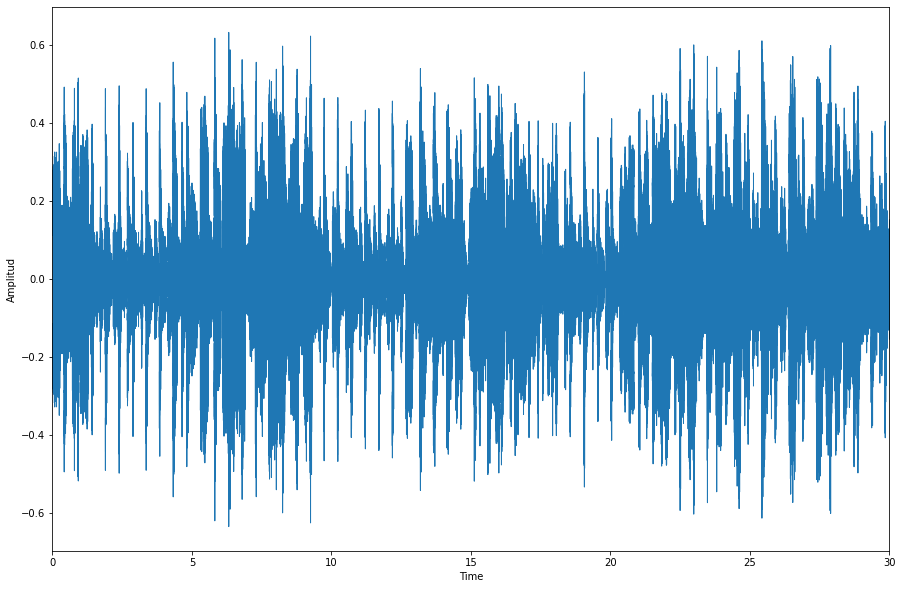

In [2]:
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(senal, sr)
plt.ylabel("Amplitud") # El eje x es Time por defecto

Ahora veremos el espectro de frecuencia. Para realizar las transformadas de Fourier usaremos numpy.

Text(0.5, 0, 'Frecuencia')

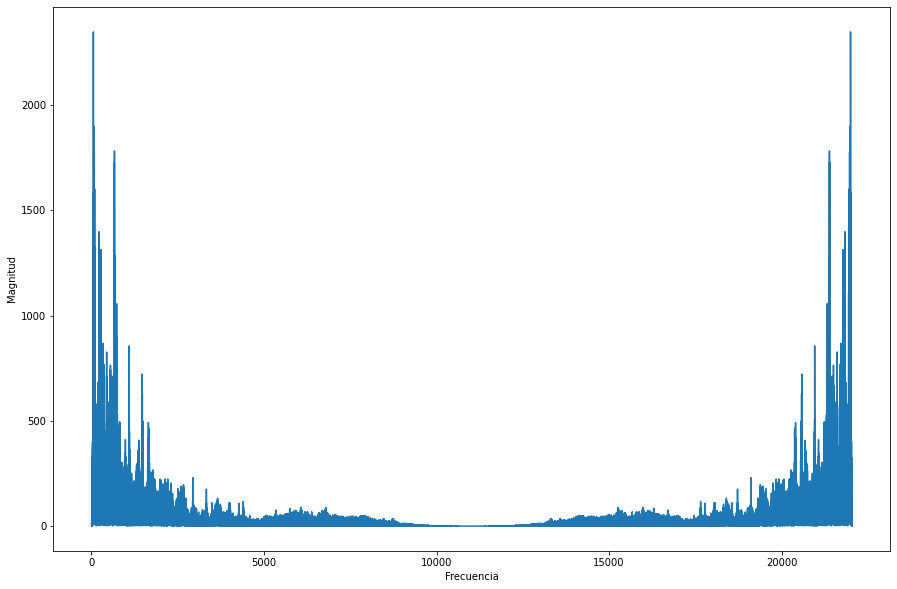

In [3]:
import numpy as np


fft = np.fft.fft(senal) # FFT -> Fast Fourier Transform

magnitud = np.abs(fft) 
# Obtenemos los valores absolutos de ftt para ver que frecuencia contribuye más al sonido

frecuencia = np.linspace(0, sr, len(magnitud))
# generamos numeros equidistantes entre 0 y sr para mapear la magnitud
plt.figure(figsize=FIG_SIZE)
plt.plot(frecuencia, magnitud)
plt.ylabel("Magnitud")
plt.xlabel("Frecuencia")

Como se puede ver, la distribucion de frecuencias es simetrica. Esto es una propiedad de la transformada de Fourier, y por simplicidad tomaremos solo la mitad.

Text(0, 0.5, 'Magnitud')

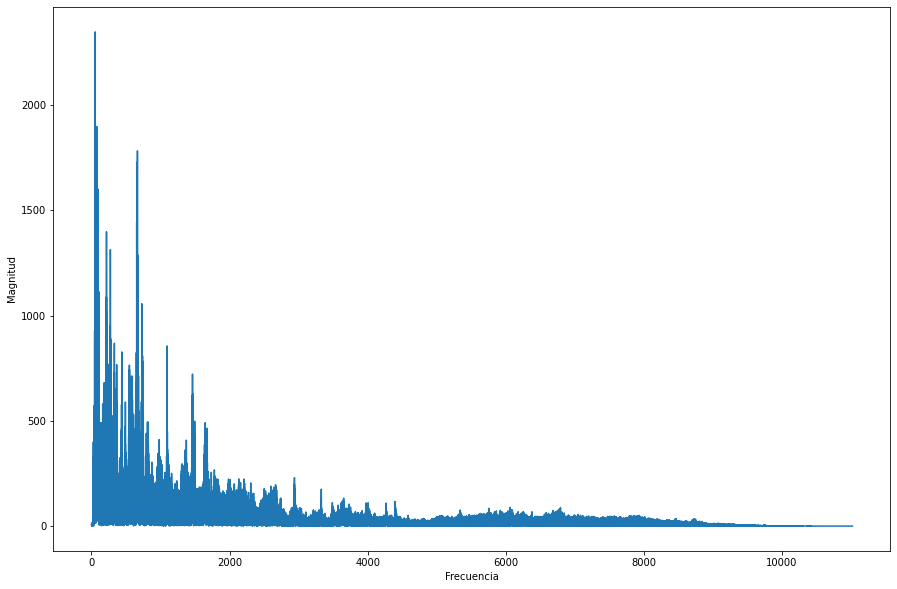

In [4]:
frecuencia_isq = frecuencia[:int(len(frecuencia)/2)]
magnitud_isq = magnitud[:int(len(frecuencia)/2)]


plt.figure(figsize=FIG_SIZE)
plt.plot(frecuencia_isq, magnitud_isq)
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")


Ahora usaremos librosa para hacer un STFT, y asi obtener el espectro de frecuencia respecto al tiempo.

Text(0, 0.5, 'Magnitud')

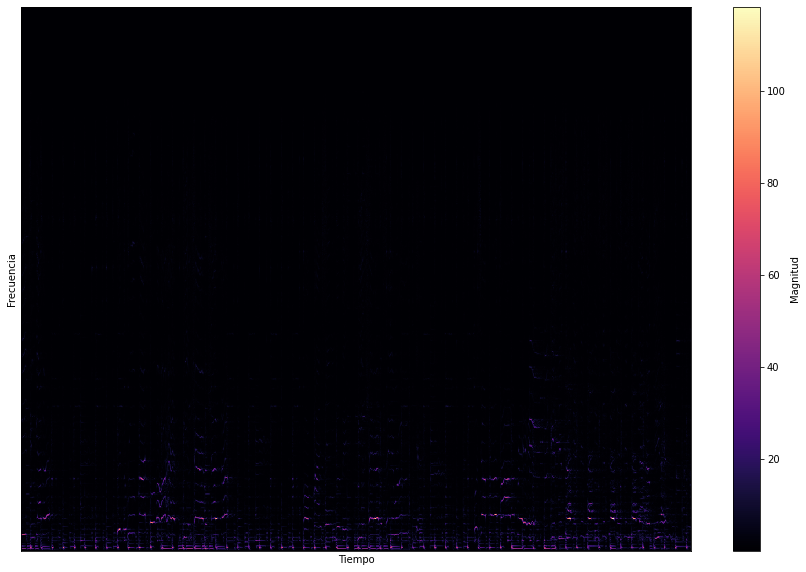

In [5]:
import scipy
n_fft = 2048 # La cantidad de puntos muestreados en cada FFT
hop_length = 512 # Cuanto nos movemos en cada FFT 
stft = librosa.core.stft(senal, hop_length= hop_length, n_fft= n_fft)
inv_stft = librosa.core.istft(np.abs(stft), hop_length = hop_length)
espectrograma = np.abs(stft) # Tomamos el abs analogamente a la magnitud


plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(espectrograma, sr=sr, hop_length=hop_length)

plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Magnitud')





El espectrograma muestra la magnitud de diferentes frecuencias de manera lineal. Para mostrar de mejor manera como son percibidas por el oido humano, usaremos el espectrograma logaritmico. Esto convierte la magnitud a decibeles.

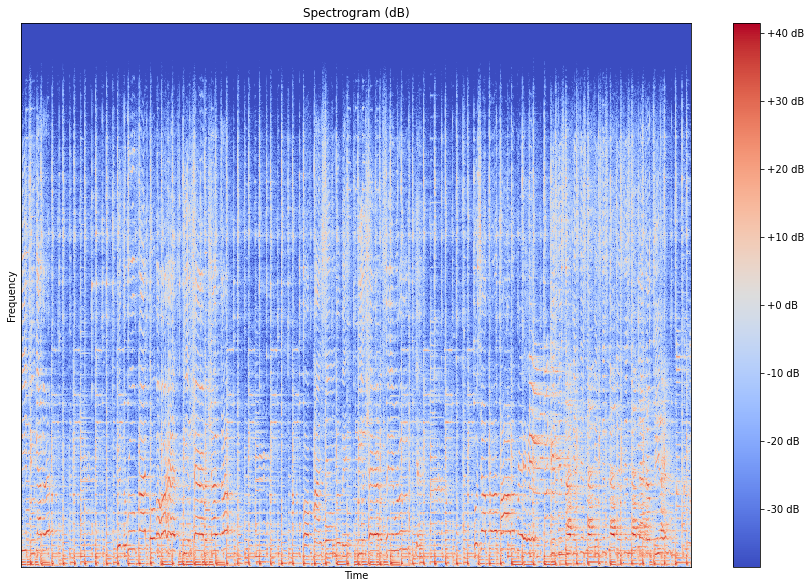

In [6]:
log_spectrogram = librosa.amplitude_to_db(espectrograma)


plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.savefig("espectrograma")




Finalmente buscaremos los MFCCs usando librosa.

Text(0.5, 1.0, 'MFCCs')

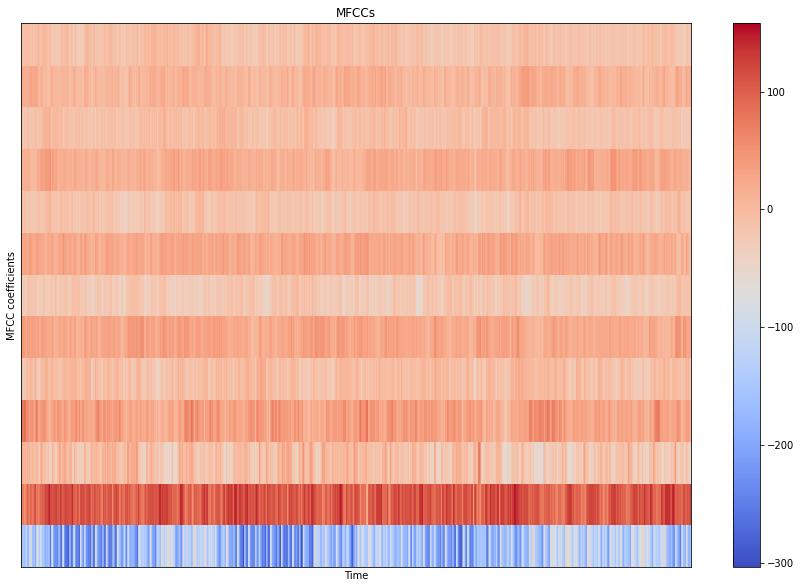

In [7]:
MFCCs = librosa.feature.mfcc(senal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
# n_mfcc representa la cantidad de coeficientes que usaremos para determinar el timbre.
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

Ambas formas pueden ser útiles al implementar redes neuronales. En el ejemplo de clasificación usarémos los MFCCs

## Parte 3: Preparar un dataset de audio


A continuación se verá un ejemplo de como preparar un dataset de archivos de audio, usando el dataset [GTZAN](http://marsyas.info/downloads/datasets.html), separando por generos musicales y guardando el dataset procesado en un archivo JSON. En este caso convertiremos los archivos .wav a sus vectores MFCC, para poder usarlos en nuestra red clasificadora.

In [12]:
import json
import os
import math
import librosa

DATASET_PATH = "datasets/genres/"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 1600
TRACK_DURATION = 30 # Segundos
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_mfcc(dataset_path, json_path, num_mfcc = 13, n_fft = 2048, hopp_length = 512, num_segments = 10):
    # num_segments se refiere a la particion de los archivos, es decir, dividiremos cada
    # archivo de audio en 10 partes, para tener mas datos.
    
    
    # crearemos un diccionario para guardar los datos
    
    data = {
        "mapping": [], # acá guardamos las distintas categorias posibles
        "labels": [], # acá guardamos los outputs esperados
        "mfcc": [] # acá guardamos los inputs en forma de vectores 
    }
    
    
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) 
    
    # Cantidad de puntos muestreados por segmento
    
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    
    # Largo esperado de vectores mfcc
    
    
    # Ahora iteramos sobre el directorio que contiene nuestros archivos
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # i es la iteracion actual
        # Dirpath es nuestro directorio actual
        # Dirnames son los nombres de todas las carpetas contenidas en el directorio
        # Filenames son todos los archivos contenidos en el directorio
        
        
        
        # Nos aseguramos que estamos en el directorio de un subgenero
        if dirpath is not dataset_path:
            # Separaremos dirpath para encontrar el genero actual
            semantic_label = dirpath.split("/")[-1] 
            # El ultimo elemento es el genero
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
            
            for f in filenames:
            # Cargamos el archivo
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # Procesamos sus segmentos por separado
                for d in range(num_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # Extraemos mfcc del intervalo seleccionado
                    mfcc = librosa.feature.mfcc(signal[start:finish],
                                    sample_rate, n_mfcc=num_mfcc,
                                                n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # Guardamos los mfcc solo si tienen el largo esperado, esto lo hacemos por si
                    # hay archivos de duraciones distintas, pues los inputs deben ser todos del mismo
                    # tamaño.
                    
                    
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        # Vamos guardando el genero segun la iteracion actual.
                        
                        print("{}, segment:{}".format(file_path, d+1))

    # Guardamos los MFCCs en un archivo JSON
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
if __name__ == "__main__":
    
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=1)
            


Processing: blues
datasets/genres/blues/blues.00005.wav, segment:1
datasets/genres/blues/blues.00002.wav, segment:1
datasets/genres/blues/blues.00003.wav, segment:1
datasets/genres/blues/blues.00004.wav, segment:1
datasets/genres/blues/blues.00001.wav, segment:1
datasets/genres/blues/blues.00000.wav, segment:1
